In [1]:
import numpy as np
import cv2
import os
import matplotlib.pyplot as plt
import pandas as pd
from PIL import Image
from scipy.optimize import minimize, Bounds

def preprocess(image, radius):
    image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)  # <-- convert to grayscale

    if radius == 37:
        gray_image = cv2.resize(image, (80, 80), interpolation=cv2.INTER_AREA)
    else:
        gray_image = cv2.resize(image, (100, 100), interpolation=cv2.INTER_AREA)

    Gauss_image = cv2.GaussianBlur(gray_image, (3, 3), 1).astype(np.float32)
    image_norm = Gauss_image / Gauss_image.max()
    return image_norm

def crop_circle_with_mask_float(img):
    h, w = img.shape
    center = (w // 2, h // 2)
    radius = min(center[0], center[1])
    Y, X = np.ogrid[:h, :w]
    mask = (X - center[0])**2 + (Y - center[1])**2 <= radius**2
    return img * mask  # retain float values


def circular_roi_mask_from_pdata(pdata, idx, d, img_shape, roi_radius=None):
    """
    Create a circular ROI mask centered along the line from particle i to j,
    at distance d from i, with optional roi_radius (defaults to ri of i).
    Returns a boolean mask of shape img_shape.
    """

    xi, yi = pdata.iloc[idx]['xi'], pdata.iloc[idx]['yi']
    xj, yj = pdata.iloc[idx]['xj'], pdata.iloc[idx]['yj']

    if roi_radius is None:
        roi_radius = pdata.iloc[idx]['ri']/3
    dx, dy = xj - xi, yj - yi
    norm = np.hypot(dx, dy)
    if norm == 0:
        raise ValueError("Particles i and j are at the same position.")
    ux, uy = dx / norm, dy / norm
    cx, cy = img_shape[1] / 2 + d * ux, img_shape[0] / 2 + d * uy
    Y, X = np.ogrid[:img_shape[0], :img_shape[1]]
    mask = (X - cx)**2 + (Y - cy)**2 <= roi_radius**2
    return mask

def rotate_image(image, angle_degrees):
    h, w = image.shape[:2]
    center = (w // 2, h // 2)
    M = cv2.getRotationMatrix2D(center, angle_degrees, 1.0)
    rotated = cv2.warpAffine(image, M, (w, h), borderMode=cv2.BORDER_CONSTANT, borderValue=0)
    return rotated

def crop_top_center_square(image, center, radius):
    h, w = image.shape[:2]
    side = int(radius)
    x1 = max(center[0] - side // 2, 0)
    x2 = min(center[0] + side // 2, w)
    y1 = 0
    y2 = min(side, h)
    return image[y1:y2, x1:x2]

def append_ij_angle_to_pdata(pdata):
    dx = pdata['xj'].to_numpy() - pdata['xi'].to_numpy()
    dy = pdata['yj'].to_numpy() - pdata['yi'].to_numpy()
    pdata = pdata.copy()
    pdata['beta'] = np.arctan2(dy, dx)
    return pdata

def get_disk_img(pdata, img):
       
    img = img[250:1200, :]  # crop top/bottom

    entry = pdata.copy()
    
    # If entry is a DataFrame with more than one row, take only the first element
    if isinstance(entry, pd.DataFrame) and len(entry) > 1:
        entry = entry.iloc[0]
    
    x = int(np.around(entry['xi']))
    y = int(np.around(entry['yi']))
    r = int(entry['ri'])

    h, w = img.shape[:2]
    y1, y2 = max(0, y - r), min(h, y + r)
    x1, x2 = max(0, x - r), min(w, x + r)
    img_crop = img[y1:y2, x1:x2]

    if img_crop.shape[0] == 0 or img_crop.shape[1] == 0:
        raise ValueError("Cropped region is empty. Check particle location or radius.")
    
    gray_img = preprocess(img_crop, r)
    gray_img = crop_circle_with_mask_float(gray_img)

    return gray_img

def get_contact_rois(F_bond, IMG_DIR, frame_lag=0):

    F_bond = append_ij_angle_to_pdata(F_bond)

    # Collect all processed images and metadata
    all_images = []
    all_metadata = []

    for frame in range(1, max(F_bond.frame)+1):   
        print(f"\rProcessing frame: {frame}", end='', flush=True) 
        
        frame_data = F_bond[F_bond['frame'] == frame]
        image_path = os.path.join(IMG_DIR, 'Ib_'+str(frame+frame_lag)+'.png')
        img = cv2.imread(image_path)

        
        # Process each particle in the frame
        for idx, pdata in frame_data.iterrows():
            # 1. Crop the particle (disk image)
            try:
                img_crop = get_disk_img(pdata, img)
            except ValueError as e:
                print(f"Skipping particle {idx}: {e}")
                continue
            
            # 2. Mask the region outside the circle
            img_masked = crop_circle_with_mask_float(img_crop)
            
            # 3. Get particle radius and center
            r = int(pdata['ri'])
            center = (img_crop.shape[1] // 2, img_crop.shape[0] // 2)
            
            # 4. Rotate by beta degrees (contact angle)
            rotation_angle = pdata['beta'] * 180 / np.pi + 90  # Convert radians to degrees
            img_rotated = rotate_image(img_masked, rotation_angle)
            
            # 5. Crop the top center square
            img_final = crop_top_center_square(img_rotated, center, r)
            
            # Store image and metadata
            all_images.append(img_final)
            all_metadata.append({
                'idx': idx,
                'frame': frame,
                'beta': pdata['beta'],
                'xi': pdata['xi'],
                'yi': pdata['yi'],
                'ri': pdata['ri']
            })
    print(f"\nTotal contacts processed: {len(all_images)}")

    return all_images, all_metadata


In [2]:
import torch
import cv2
import torch.nn.functional as F

import torch.nn as nn
from torchvision import models, transforms

def get_model(device, output_dim=2):   
    """
    Build a ResNet18-based regression model for contact force and angle prediction.    
    Parameters
    ----------
    device : torch.device
        Device to place the model on ('cuda' or 'cpu')
    output_dim : int, optional
        Number of output values (default=2 for [force, angle])
    
    Returns
    -------
    model : torchvision.models.ResNet
        Configured ResNet18 model ready for inference or training
    """
    # 1. Load Pre-trained Model
    model = models.resnet18(weights=models.ResNet18_Weights.DEFAULT)
    
    # 2. Freeze the 'Body' (Feature Extractor)
    for param in model.parameters():
        param.requires_grad = False
        
    # 3. Replace the 'Head' (Classifier -> Regressor)
    num_ftrs = model.fc.in_features  # 512
    
    model.fc = nn.Sequential(
        nn.Linear(num_ftrs, 256),
        nn.ReLU(),
        nn.Dropout(0.2),            # Drop 20% of neurons to prevent overfitting
        nn.Linear(256, output_dim)  # Output: [Force, Angle]
    )
    
    # Move to GPU/CPU
    model = model.to(device)
    return model


def StressSolve_residue_torch(xxi, xxj, f, alpha, beta, fsigma, rm, power, eps = 1e-10):
    """
    Vectorized batch version of StressSolve_residue including residual stress tensor.
    
    xxi, xxj: [HW] tensors, particle coordinates
    f, alpha, beta: [z] tensors, contact info
    fsigma, rm, power: scalars
    eps: small number to avoid division by zero
    """
    device = xxi.device
    z = f.shape[0]
    HW = xxi.shape[0]

    # Adjust beta
    beta_adj = -beta + torch.pi / 2  # [z]

    pioverfsigma = torch.pi / fsigma
    twooverpi = 2 / torch.pi

    # Reshape for broadcasting
    xxi_exp = xxi.unsqueeze(0)   # [1, HW]
    xxj_exp = xxj.unsqueeze(0)   # [1, HW]
    f_exp = f.unsqueeze(1)       # [z, 1]
    alpha_exp = alpha.unsqueeze(1)  # [z, 1]
    beta_exp = beta_adj.unsqueeze(1) # [z, 1]

    # Chord angles
    b = beta_exp + torch.pi / 2
    a = alpha_exp
    b2 = torch.where(a < 0, b + (torch.pi + 2 * a), b - (torch.pi - 2 * a))

    # Chord points
    x1 = rm * torch.sin(b)
    y1 = rm * torch.cos(b)
    x2 = rm * torch.sin(b2)
    y2 = rm * torch.cos(b2)

    ch0 = x2 - x1
    ch1 = y2 - y1
    chn = torch.sqrt(ch0 ** 2 + ch1 ** 2 + eps)
    ch0 = ch0 / chn
    ch1 = ch1 / chn

    # r vector
    r10 = xxi_exp - x1         # [z, HW]
    r11 = -xxj_exp - y1        # [z, HW]
    r1n = torch.sqrt(r10**2 + r11**2 + eps)

    # Angles and s1
    costh1 = (r10 * ch0 + r11 * ch1) / r1n
    costh1 = torch.clamp(costh1, -1 + eps, 1 - eps)
    signth = torch.where(r11 * ch0 > r10 * ch1, 1.0, -1.0)
    th1 = signth * torch.acos(costh1)

    s1 = -(f_exp * twooverpi) / r1n * costh1
    th = th1 - beta_exp - alpha_exp

    # Stress components from contacts
    sigmaxx = torch.sum(s1 * torch.sin(th)**2, dim=0)  # [HW]
    sigmayy = torch.sum(s1 * torch.cos(th)**2, dim=0)
    sigmaxy = torch.sum(0.5 * s1 * torch.sin(2*th), dim=0)

    # Residual stress tensor
    R_squared = xxi**2 + xxj**2  # Avoid sqrt when possible
    R = torch.sqrt(R_squared + eps)  # [HW]
    K_RESIDUAL = -fsigma / (torch.pi * power * rm**power) * torch.arcsin(torch.tensor(1., device=device)**0.5)
    
    rm_power = rm**power
    R_power = R**power
    sigma_r_res = K_RESIDUAL * (rm_power - R_power)
    sigma_theta_res = K_RESIDUAL * (rm_power - (power+1) * R_power)

    Theta = torch.atan2(xxi, xxj)
    sigma_xx_res = sigma_r_res * torch.cos(Theta)**2 + sigma_theta_res * torch.sin(Theta)**2
    sigma_yy_res = sigma_r_res * torch.sin(Theta)**2 + sigma_theta_res * torch.cos(Theta)**2
    tau_xy_res = (sigma_r_res - sigma_theta_res) * torch.sin(Theta) * torch.cos(Theta)

    # Total stress
    sigmaxx_tot = sigmaxx + sigma_xx_res
    sigmayy_tot = sigmayy + sigma_yy_res
    sigmaxy_tot = sigmaxy + tau_xy_res

    # Final residue
    aa = torch.sqrt((sigmaxx_tot - sigmayy_tot)**2 + 4 * sigmaxy_tot**2)
    result = torch.sin(pioverfsigma * aa)**2
    result = torch.nan_to_num(result, nan=0.0, posinf=0.0, neginf=0.0)

    return result  # [HW], one residue per particle

# Global cache for coordinate meshes to avoid repeated computation
_mesh_cache = {}

def synth_img_pytorch_residue(fsigma, rm, px, f, alpha, beta, device='cuda'): 
    # Use cached meshes when possible
    cache_key = (px, rm, device)
    if cache_key not in _mesh_cache:
        x = torch.linspace(-rm, rm, px, device=device) 
        xxi, xxj = torch.meshgrid(x, x, indexing='ij') 
        xxi_flat = xxi.reshape(-1) 
        xxj_flat = xxj.reshape(-1) 
        r2 = xxi_flat**2 + xxj_flat**2 
        mask = r2 <= rm**2 
        _mesh_cache[cache_key] = {
            'xxi_flat': xxi_flat,
            'xxj_flat': xxj_flat,
            'mask': mask,
            'img_template': torch.zeros(px * px, device=device)
        }
    
    cached = _mesh_cache[cache_key]
    xxi_in = cached['xxi_flat'][cached['mask']] 
    xxj_in = cached['xxj_flat'][cached['mask']] 
    
    intensity = StressSolve_residue_torch(xxi_in, xxj_in, f, alpha, beta, fsigma, rm, power = 10) 
    
    # Reuse template and only update masked values
    img = cached['img_template'].clone()
    img[cached['mask']] = intensity 
    return img.reshape(px, px)

def gaussian_kernel(kernel_size=3, sigma=1.0, device='cuda'):
    # 建立 1D Gaussian kernel
    x = torch.arange(kernel_size, dtype=torch.float32, device=device) - (kernel_size - 1) / 2
    gauss = torch.exp(-x**2 / (2 * sigma**2))
    gauss = gauss / gauss.sum()
    # 2D kernel = 外積
    kernel2d = gauss[:, None] @ gauss[None, :]
    return kernel2d

def smooth_image(img, kernel_size=3, sigma=1.0):
    """
    img: [H, W] tensor, single channel
    output: [H, W] tensor,平滑後影像
    """
    device = img.device
    kernel = gaussian_kernel(kernel_size, sigma, device=device)
    kernel = kernel.unsqueeze(0).unsqueeze(0)  # [1,1,kH,kW]

    img = img.unsqueeze(0).unsqueeze(0)  # [1,1,H,W]
    smoothed = F.conv2d(img, kernel, padding=kernel_size//2)
    return smoothed.squeeze(0).squeeze(0)


def fit_disk_residue(photo_img, fsigma, rm, px, f0, alpha0, beta, lr, n_iter=1000, device='cuda',verbose = 0,
                      tol=5e-4, patience=300):
    """
    Fit force magnitudes (f0) and angles (alpha0) to match the photoelastic image.
    Optimized version with tensor reuse and reduced memory allocations.
    """
    # Ensure requires_grad
    f0 = f0.clone().detach().to(device).requires_grad_(True)
    alpha0 = alpha0.clone().detach().to(device).requires_grad_(True)
    beta = beta.to(device)  # Keep beta on GPU

    optimizer = torch.optim.Adam([f0, alpha0], lr=lr)

    prev_loss = None
    patience_counter = 0
    loss_history = []
    
    # Pre-compute constants to avoid repeated calculations
    pi_half = torch.tensor(3.14159/2, device=device)
    torque_weight = torch.tensor(100000.0, device=device)

    for i in range(n_iter):
        optimizer.zero_grad()

        # Calculate absolute forces (can't use out= with gradients)
        f0_pos = torch.abs(f0)
        synth = synth_img_pytorch_residue(fsigma, rm, px, f0_pos, alpha0, beta)
        
        # Calculate image reconstruction loss  
        smoothed = smooth_image(synth)
        image_loss = ((smoothed - photo_img) ** 2).mean()
        
        # Calculate net torque and force losses
        torques = torch.sin(alpha0) * (rm * f0_pos)
        
        # Compute force components
        angle_term = alpha0 - beta + pi_half
        fx = torch.cos(angle_term) * f0_pos
        fy = torch.sin(angle_term) * f0_pos
        
        net_torque = torch.sum(torques)
        net_f_x = torch.sum(fx)
        net_f_y = torch.sum(fy)
        
        torque_loss = torque_weight * net_torque * net_torque
        force_loss = net_f_x * net_f_x + net_f_y * net_f_y
        
        # Combine losses
        loss = image_loss + torque_loss + force_loss

        if verbose:
            if i%10==0:
                print(f"Iter {i}: Total Loss={loss.item():.4f}, Image Loss={image_loss.item():.4f}, Torque Loss={torque_loss.item():.4f}, Force Loss={force_loss.item():.4f}")

        if torch.isnan(loss) or torch.isinf(loss):
            print("Loss exploded")
            break

        loss.backward()
        optimizer.step()

        current_loss = loss.item()
        loss_history.append(current_loss)

        # Early stopping
        if prev_loss is not None:
            if prev_loss - current_loss < tol:
                patience_counter += 1
            else:
                patience_counter = 0
            if patience_counter >= patience:
                break

        prev_loss = current_loss

    return f0.detach().cpu().numpy(), alpha0.detach().cpu().numpy(), loss.detach(), loss_history

Load bond pkl file that contains neighbor information

In [3]:

EXP_NAME = 'TPE_20260122A01_N=265x2_5e-4rps_10fps_steady_2000frames'

IMG_DIR = os.path.join(r'N:\PROJ_TPE', EXP_NAME)
traj_filename = os.path.join(r'M:\Archive\Proj_TPE\Disk_traj_files', f'{EXP_NAME}.pkl')
bond_filename = os.path.join(r'M:\Archive\Proj_TPE\Contact_bond_files', f'CONTACT_BOND_{EXP_NAME}.pkl')
OUT_DIR = r'M:\Archive\Proj_TPE\Force Inversion'


F_bond = pd.read_pickle(bond_filename)
F_traj = pd.read_pickle(traj_filename)
frame_lag = 1

model_path = os.path.join(os.getcwd(), 'models', 'Contact_Force_ResNet_20260130.pth')

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = get_model(DEVICE)
model.load_state_dict(torch.load(model_path))

<All keys matched successfully>

### Make initial guess for forces and angles

First crop and append all ROIs, append to list.
Then make initial guess in batches, append back to F_bond (~ 30 min)

In [ ]:
# Define transforms (same as training)
IMAGENET_MEAN = [0.485, 0.456, 0.406]
IMAGENET_STD = [0.229, 0.224, 0.225]

data_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.Grayscale(num_output_channels=3),
    transforms.ToTensor(),
    transforms.Normalize(mean=IMAGENET_MEAN, std=IMAGENET_STD)
])

BATCH_SIZE = 64
model.eval()
all_predictions = []

print('Cropping contact ROIs...')
all_images, all_metadata = get_contact_rois(F_bond, IMG_DIR, frame_lag=frame_lag)

print(f"Total images to process: {len(all_images)}", flush=True)
print(f"Processing in batches of {BATCH_SIZE}...", flush=True)

############################# MODEL PREDICTION ###############################
with torch.no_grad():
    for batch_idx in range(0, len(all_images), BATCH_SIZE):
        batch_end = min(batch_idx + BATCH_SIZE, len(all_images))
        batch_size_actual = batch_end - batch_idx
        
        # Convert only this batch of images to PIL and apply transforms
        batch_images = []
        for i in range(batch_idx, batch_end):
            img = all_images[i]
            # Convert to PIL
            pil_img = Image.fromarray((img * 255).astype(np.uint8)) if img.max() <= 1.0 else Image.fromarray(img.astype(np.uint8))
            # Apply transforms
            tensor_img = data_transform(pil_img)
            batch_images.append(tensor_img)
        
        # Stack batch and move to device
        batch_tensor = torch.stack(batch_images).to(DEVICE)
        batch_predictions = model(batch_tensor)
        batch_predictions = batch_predictions.cpu().numpy()
        all_predictions.append(batch_predictions)
        
        
        print(f"Processed batch {batch_idx // BATCH_SIZE + 1}: samples {batch_idx} to {batch_end}", flush=True)
        
        # Explicitly free memory
        del batch_tensor, batch_images
        torch.cuda.empty_cache() if torch.cuda.is_available() else None

# Concatenate all predictions
predictions = np.vstack(all_predictions)

# Store predictions with metadata
for i, meta in enumerate(all_metadata):
    meta['force_pred'] = predictions[i, 0]
    meta['angle_pred'] = predictions[i, 1]

print(f"\nCompleted! Processed {len(all_metadata)} particles with ResNet predictions", flush=True)

############### Append predictions back to F_bond ####################################
F_bond_pred = F_bond.copy()

# Initialize new columns with NaN
F_bond_pred['force_pred'] = np.nan
F_bond_pred['angle_pred'] = np.nan

# Fill in predictions at corresponding indices
for meta in all_metadata:
    idx = meta['idx']
    F_bond_pred.loc[idx, 'force_pred'] = meta['force_pred']
    F_bond_pred.loc[idx, 'angle_pred'] = meta['angle_pred']


In [8]:
# Write F_bond_pred to pickle
output_path = os.path.join(OUT_DIR, f'PREDICTION_{EXP_NAME}.pkl')
F_bond_pred.to_pickle(output_path)

### Starts fitting 

In [4]:
fsigma = 225
plot_every = 0 # Once this open(plot_every = 1), plot figure of balls
verbose = 0

# Define output CSV path
output_csv_path = os.path.join(OUT_DIR, f'FORCE_FITTED_TEMP_{EXP_NAME}.csv')

F_bond_pred = pd.read_pickle(os.path.join(OUT_DIR, f'PREDICTION_{EXP_NAME}.pkl'))
F_bond_pred = append_ij_angle_to_pdata(F_bond_pred)

#for frame in sorted(F_bond_pred['frame'].unique()):
for frame in range(1186, max(F_bond_pred.frame)+1):
#for frame in np.arange(2,3):  # For testing specific frames   
    print(f"\rProcessing frame: {frame}", end='', flush=True) 
    
    # Initialize list for this frame's results
    frame_data_out = []
    
    image_path = os.path.join(IMG_DIR, 'Ib_'+str(frame+frame_lag)+'.png')
    img = cv2.imread(image_path)

    frame_force = F_traj[F_traj.frame==frame]
    frame_data = F_bond_pred[F_bond_pred['frame'] == frame]
    
    for particle_id, pdata in frame_data.groupby('i'):
        z = len(pdata) #CONTACT NUMBER 
        pdata = pdata.reset_index(drop=True)
        
        ########################## If i is singular, skip ############################
        if z == 1:
            continue
        ######################### Begin inversion if z>1 ############################
        else:
             #give beta column to pdata
            GrayImg = get_disk_img(pdata, img) 
            
            # Ensure grayscale (convert BGR to grayscale if needed)
            if len(GrayImg.shape) == 3:
                GrayImg = cv2.cvtColor(GrayImg, cv2.COLOR_BGR2GRAY)
            
            # Normalize to [0, 1]
            GrayImg = GrayImg.astype(np.float32) / 255.0 if GrayImg.max() > 1 else GrayImg.astype(np.float32)
            
            pdata_out = pdata.copy()        
            rm = pdata.iloc[0]['ri']/37*6/1000 # rm is radius meter, value of radius
            img_size = GrayImg.shape[0]
        
            ############################ Initial force guesses ################################
            alphas = pdata['angle_pred'].to_numpy().copy()   #call beta from bond file data
            betas = pdata['beta'].to_numpy().copy()   #call beta from bond file data
            forces = pdata['force_pred'].to_numpy().copy()   #call beta from bond file data

            #alphas, forces = forceBalance(forces.copy(), alphas.copy(), betas) # Apply force balance

            if verbose:
                print(f"Particle id: {particle_id}, Contact number z={z}")
                print(f"Initial forces: {forces}")
                print(f"Initial alphas: {alphas}")

            ############################# Set initial guesses to pytorch #######################################

            f0_gpu = torch.tensor(forces.tolist(), dtype=torch.float32, device='cuda')  # Force magnitude
            alpha0_gpu = torch.tensor(alphas.tolist(), dtype=torch.float32, device='cuda')  # Force angles
            betas_gpu = torch.tensor(betas.tolist(), dtype=torch.float32, device='cuda')  # Force angles
            GrayImg = torch.tensor(GrayImg, dtype=torch.float32, device='cuda')

            guess_im = synth_img_pytorch_residue(fsigma, rm, img_size, f0_gpu, alpha0_gpu, betas_gpu, device='cuda')
            
            ############################ Start fitting #########################################            
            res = fit_disk_residue(GrayImg, fsigma, rm, img_size, f0_gpu, alpha0_gpu, betas_gpu, 
                                   verbose=verbose,tol=1e-3, patience=10, lr=4e-2, n_iter=1000)
            f_fit, alpha_fit, fitted_loss, loss_hist = res
            
            ####################### Plot results if desired ###########################
            if verbose:
                print('Fitted Loss:', fitted_loss.cpu().numpy())
                print(f"Fitted forces: {f_fit}")
                print(f"Fitted alphas: {alpha_fit}")

            if plot_every and fitted_loss.cpu().numpy()> 0:
                fit_im = synth_img_pytorch_residue(
                    fsigma, rm, img_size,
                    torch.tensor(f_fit, dtype=torch.float32, device='cuda'),
                    torch.tensor(alpha_fit, dtype=torch.float32, device='cuda'),
                    betas_gpu, device='cuda'
                )

                plt.figure(figsize = (6,2))
                plt.subplot(1, 3, 1)
                plt.imshow(GrayImg.cpu().numpy(), cmap='gray', vmax = 1)
                plt.title(f"id = {particle_id} \n exp", fontsize=10)
                plt.axis('off')

                plt.subplot(1, 3, 2)
                plt.imshow(smooth_image(guess_im, kernel_size=3, sigma=1.0).cpu().numpy(), cmap='gray', vmax=1)
                plt.title("guess", fontsize=10)
                plt.axis('off')

                plt.subplot(1, 3, 3)
                plt.imshow(smooth_image(fit_im, kernel_size=3, sigma=1.0).cpu().numpy(), cmap='gray', vmax=1)
                plt.title("fit", fontsize=10)
                plt.axis('off')
                plt.show()
            #################### Append particle results to frame data #############

            pdata_out['force'] = f_fit
            pdata_out['alpha'] = alpha_fit
            pdata_out['fitLoss'] = fitted_loss.cpu().numpy()

        frame_data_out.append(pdata_out)
    
    # Append this frame's results to CSV file (efficient append without reading entire file)
    if frame_data_out:
        frame_results = pd.concat(frame_data_out, ignore_index=True)
        
        # Write header only for the first frame
        write_header = not os.path.exists(output_csv_path)
        frame_results.to_csv(output_csv_path, mode='a', header=write_header, index=False)

print(f"\nProcessing complete! Results saved to: {output_csv_path}")



Processing frame: 2000
Processing complete! Results saved to: M:\Archive\Proj_TPE\Force Inversion\FORCE_FITTED_TEMP_TPE_20260122A01_N=265x2_5e-4rps_10fps_steady_2000frames.csv


### Calculate ij/ji force difference for validation

Total ij/ji pairs found: 663892

Force statistics:
Mean absolute force difference: 0.0672 N

Alpha statistics:
Mean absolute alpha difference: 0.1275 rad (7.31°)
Pairs with opposite alpha (within 0.1 rad of π): 0 (0.0%)


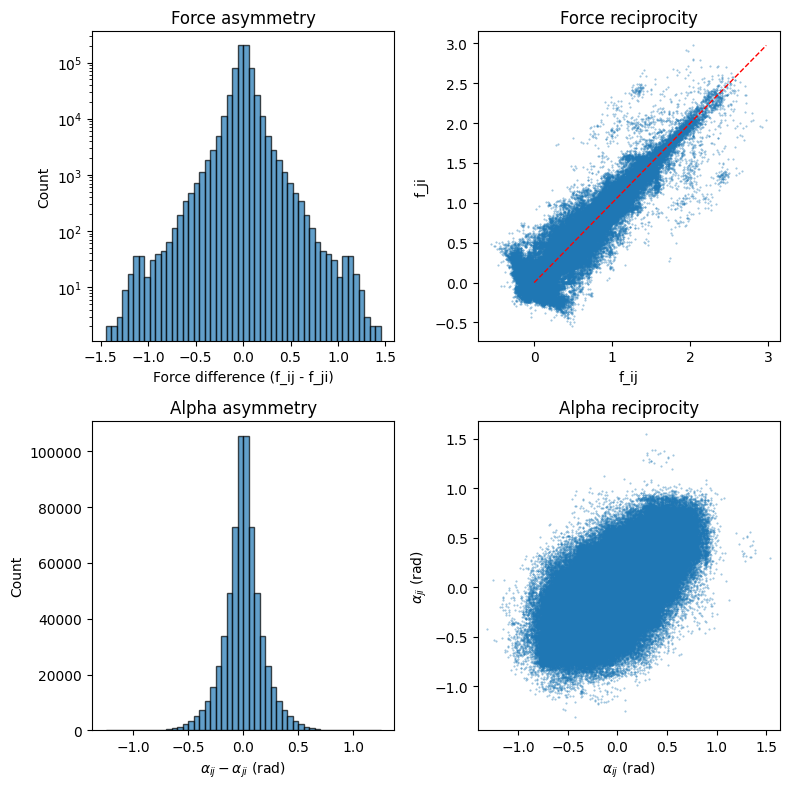

In [9]:
# Load the fitted results from CSV
F_bond_out = pd.read_csv(os.path.join(OUT_DIR, f'FORCE_FITTED_TEMP_{EXP_NAME}.csv'))
F_bond_out.drop_duplicates(subset=['frame', 'i', 'j'], keep='first', inplace=True)

# Create a copy with swapped i and j to find reciprocal contacts
F_swap = F_bond_out[['frame', 'i', 'j', 'force', 'alpha', 'fitLoss']].copy()
F_swap.columns = ['frame', 'j', 'i', 'force_ji', 'alpha_ji', 'fitLoss_ji']

# Merge to get both ij and ji forces in one row
F_compare = F_bond_out.merge(F_swap, on=['frame', 'i', 'j'], how='inner')

# Compute force differences
F_compare['force_diff'] = F_compare['force'] - F_compare['force_ji']
F_compare['force_ratio'] = F_compare['force'] / (F_compare['force_ji'] + 1e-10)

# Compute alpha differences (accounting for periodicity)
F_compare['alpha_diff'] = abs(F_compare['alpha']) - abs(F_compare['alpha_ji'])
# Normalize angular difference to [-pi, pi]
F_compare['alpha_diff_norm'] = np.arctan2(
    np.sin(F_compare['alpha_diff']), 
    np.cos(F_compare['alpha_diff'])
)

# Check if alphas are opposite (should differ by ~π for action-reaction pairs)
F_compare['alpha_opposite'] = np.abs(np.abs(F_compare['alpha_diff_norm']) - np.pi) < 0.1

print(f"Total ij/ji pairs found: {len(F_compare)}")
print(f"\nForce statistics:")
print(f"Mean absolute force difference: {F_compare['force_diff'].abs().mean():.4f} N")
print(f"\nAlpha statistics:")
print(f"Mean absolute alpha difference: {F_compare['alpha_diff_norm'].abs().mean():.4f} rad ({np.degrees(F_compare['alpha_diff_norm'].abs().mean()):.2f}°)")
print(f"Pairs with opposite alpha (within 0.1 rad of π): {F_compare['alpha_opposite'].sum()} ({100*F_compare['alpha_opposite'].mean():.1f}%)")

# Plot histograms and scatter plots
fig = plt.figure(figsize=(8, 8))

# Force difference histogram
plt.subplot(2, 2, 1)
plt.hist(F_compare['force_diff'], bins=50, edgecolor='k', alpha=0.7)
plt.xlabel('Force difference (f_ij - f_ji)')
plt.ylabel('Count')
plt.yscale('log')
plt.title('Force asymmetry')

# Force reciprocity scatter
plt.subplot(2, 2, 2)
plt.scatter(F_compare['force'], F_compare['force_ji'], s=0.2, alpha=0.5)
plt.plot([0, F_compare['force'].max()], [0, F_compare['force'].max()], 'r--', lw=1)
plt.xlabel('f_ij')
plt.ylabel('f_ji')
plt.title('Force reciprocity')


# Alpha difference histogram
plt.subplot(2, 2, 3)
plt.hist(F_compare['alpha_diff_norm'], bins=50, edgecolor='k', alpha=0.7)
plt.xlabel(r'$\alpha_{ij} - \alpha_{ji}$ (rad)')
plt.ylabel('Count')
plt.title('Alpha asymmetry')

# Alpha reciprocity scatter
plt.subplot(2, 2, 4)
plt.scatter(F_compare['alpha'], F_compare['alpha_ji'], s=0.2, alpha=0.5)
plt.xlabel(r'$\alpha_{ij}$ (rad)')
plt.ylabel(r'$\alpha_{ji}$ (rad)')
plt.title('Alpha reciprocity')
plt.axis('equal')

plt.tight_layout()
plt.show()


### Check all ij/ji pairs, make all f and alpha equal to the one with smaller fitLoss

In [10]:
# Make a copy and take absolute values of all forces
F_bond_corrected = F_bond_out.copy()
F_bond_corrected['force'] = np.abs(F_bond_corrected['force'])

# Create a mapping: for each contact, store the better (lower loss) values from its ij/ji pair
# Key: (frame, i, j), Value: (best_force, best_alpha)
best_values = {}

for _, row in F_compare.iterrows():
    frame = int(row['frame'])
    i = int(row['i'])
    j = int(row['j'])
    
    # Determine which side has lower loss
    if row['fitLoss'] <= row['fitLoss_ji']:
        # ij is better, use its values for both ij and ji
        best_force = np.abs(row['force'])
        best_alpha = row['alpha']
    else:
        # ji is better, use its values for both ij and ji
        best_force = np.abs(row['force_ji'])
        best_alpha = row['alpha_ji']
    
    # Store the best value for both ij and ji contacts
    best_values[(frame, i, j)] = (best_force, best_alpha)
    best_values[(frame, j, i)] = (best_force, best_alpha)

# Now vectorized update: only update contacts that are in reciprocal pairs
for idx, row in F_bond_corrected.iterrows():
    key = (int(row['frame']), int(row['i']), int(row['j']))
    if key in best_values:
        F_bond_corrected.loc[idx, 'force'] = best_values[key][0]
        F_bond_corrected.loc[idx, 'alpha'] = best_values[key][1]

print(f"Total contacts: {len(F_bond_corrected)}")
print(f"Contacts with reciprocal pairs corrected: {len(best_values)//2}")
print(f"Contacts without reciprocal pairs (unchanged): {len(F_bond_corrected) - len(best_values)//2}")

Total contacts: 741830
Contacts with reciprocal pairs corrected: 331946
Contacts without reciprocal pairs (unchanged): 409884


### Check results by drawing full-field synth img from fitted resuls

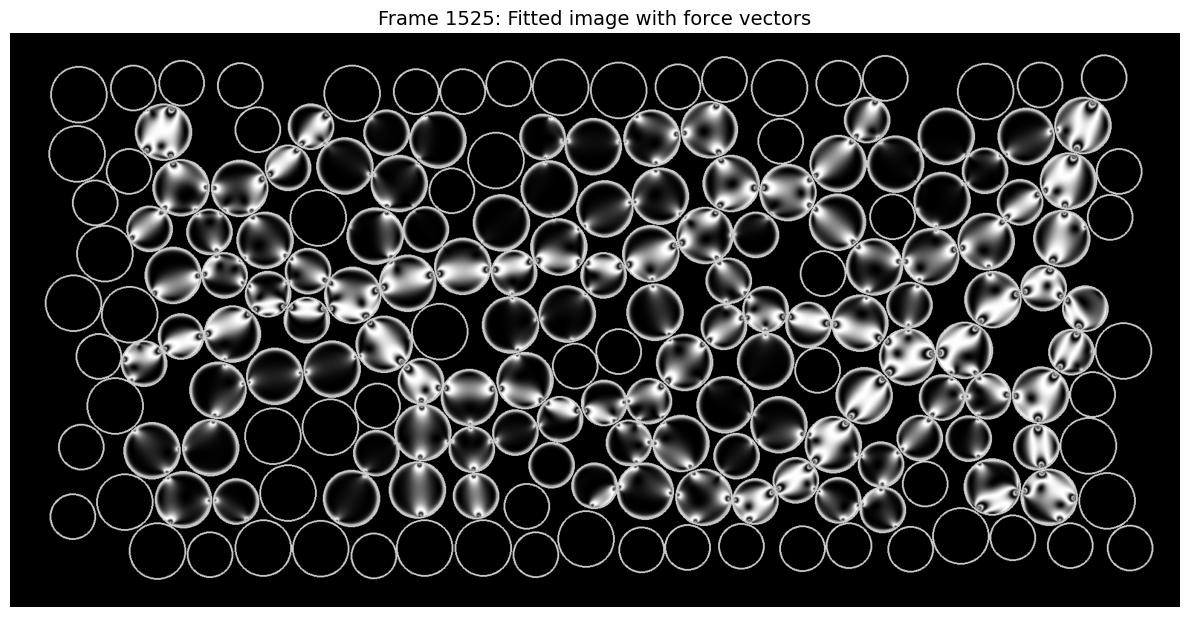

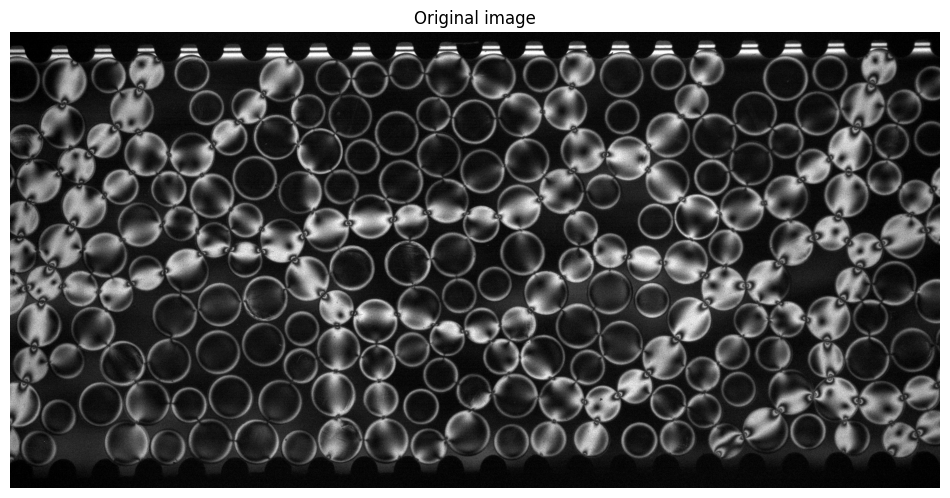

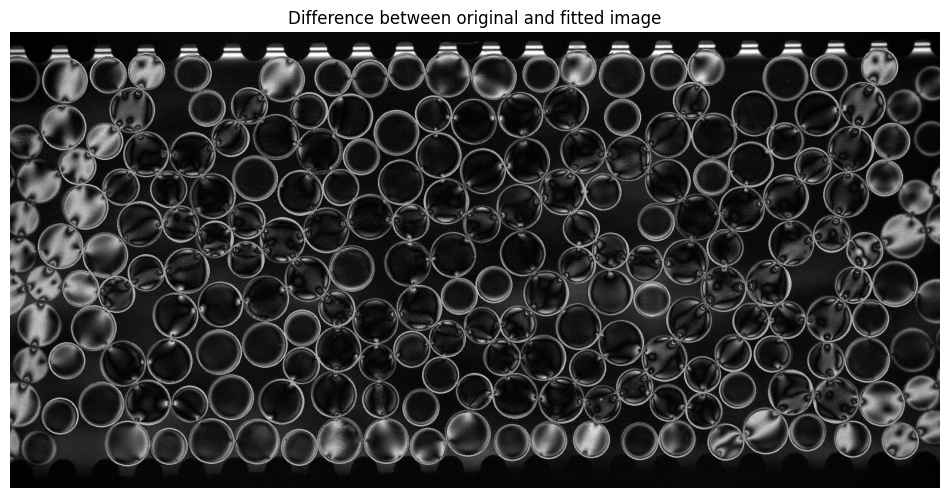

In [11]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

fsigma = 225
frame = 1525
f = F_bond_corrected[F_bond_corrected.frame==frame].copy()

# Load the original PE image
image_path = os.path.join(IMG_DIR, 'Ib_'+str(frame+frame_lag)+'.png')
orig_img = cv2.imread(image_path)
orig_img = orig_img[250:1200, :]  # Apply the same crop as in get_img_and_force

output_img = np.zeros_like(orig_img, dtype=np.float32)
count_img = np.zeros_like(orig_img, dtype=np.float32)

for particle_id, entry in f.groupby('i'):
    x = int(np.around(entry['xi'].iloc[0]))
    y = int(np.around(entry['yi'].iloc[0]))
    r = int(entry['ri'].iloc[0])
    h, w = orig_img.shape[:2]
    y1, y2 = max(0, y - r), min(h, y + r)
    x1, x2 = max(0, x - r), min(w, x + r)
    crop_h, crop_w = y2 - y1, x2 - x1

    # Only plot if fit results exist and are valid
    if 'force' in entry and 'alpha' in entry:
        z = len(entry['force'])
        if z > 1:
            rm = entry['ri'].iloc[0]/37*6/1000
            px = crop_h
            f0 = torch.tensor((entry['force']).tolist(), dtype=torch.float32, device='cuda')
            alpha0 = torch.tensor(entry['alpha'].tolist(), dtype=torch.float32, device='cuda')
            beta = torch.tensor(entry['beta'].tolist(), dtype=torch.float32, device='cuda')
            fit_im = synth_img_pytorch_residue(fsigma, rm, px, f0, alpha0, beta, device='cuda')
            im_smoothed = smooth_image(fit_im, kernel_size=3, sigma=1.0)
            fit_img_np = im_smoothed.cpu().numpy()
            fit_img_cropped = crop_circle_with_mask_float(fit_img_np)
            fit_img_resized = cv2.resize(fit_img_cropped, (crop_w, crop_h), interpolation=cv2.INTER_LINEAR)
            if len(orig_img.shape) == 3 and orig_img.shape[2] == 3:
                fit_img_resized = np.stack([fit_img_resized]*3, axis=-1)
            output_img[y1:y2, x1:x2] += fit_img_resized
            count_img[y1:y2, x1:x2] += (fit_img_resized > 0).astype(np.float32)

# Plot empty circles for disks without contacts
all_particle = F_traj[F_traj.frame==frame]

for _, row in all_particle.iterrows():
    cx = int(round(float(row.x)))
    cy = int(round(float(row.y)))
    center = (cx, cy)
    radius = int(round(float(row.rpx)))

    h_out, w_out = output_img.shape[:2]
    if radius <= 0 or cx < 0 or cy < 0 or cx >= w_out or cy >= h_out:
        continue

    color = 0.8
    thickness = 2

    if output_img.ndim == 3 and output_img.shape[2] == 3:
        cv2.circle(output_img, center, radius, (color, color, color), thickness)
    else:
        cv2.circle(output_img, center, radius, color, thickness)

count_img[count_img == 0] = 1
final_img = output_img

orig_img = orig_img/orig_img.max()
diff_img = cv2.absdiff((orig_img).astype(np.float32), final_img.astype(np.float32))

# Convert grayscale to RGB for overlaying colored arrows
orig_gray = cv2.cvtColor((orig_img*255).astype(np.uint8), cv2.COLOR_BGR2GRAY)

# Plot 1: All fitted balls overlaid with force vectors
fig, ax = plt.subplots(figsize=(12, 12))
ax.imshow(final_img.astype(np.float32), cmap='gray')

# Draw force vectors from contact points
arrow_scale = 50
if 0:
    for _, contact in f.iterrows():
        xi = float(contact['xi'])
        yi = float(contact['yi'])
        xj = float(contact['xj'])
        yj = float(contact['yj'])
        ri = float(contact['ri'])
        
        force_mag = float(contact['force'])
        alpha = float(contact['alpha'])
        beta = float(contact['beta'])
        
        # Calculate contact point
        dx = xj - xi
        dy = yj - yi
        dist_ij = np.sqrt(dx**2 + dy**2)
        
        if dist_ij > 0:
            ux = dx / dist_ij
            uy = dy / dist_ij
            
            contact_x = xi + ri * ux
            contact_y = yi + ri * uy
            
            theta = -beta + alpha
            fx = force_mag * np.cos(theta) * arrow_scale
            fy = -force_mag * np.sin(theta) * arrow_scale
            
            ax.arrow(contact_x, contact_y, fx, fy, 
                    head_width=5, head_length=8, 
                    fc='red', ec='red', 
                    linewidth=1.5, alpha=0.7)

ax.set_xlim(0, final_img.shape[1])
ax.set_ylim(final_img.shape[0], 0)
ax.axis('off')
ax.set_title(f'Frame {frame}: Fitted image with force vectors', fontsize=14)
plt.tight_layout()
plt.show()

# Plot 2: Original image
plt.figure(figsize=(12, 12))
plt.imshow((orig_img).astype(np.float32), cmap='gray')
plt.title('Original image')
plt.axis('off')
plt.show()

# Plot 3: Difference between original and fitted
plt.figure(figsize=(12, 12))
plt.imshow(diff_img, cmap='gray')
plt.title('Difference between original and fitted image')
plt.axis('off')
plt.show()


### Save to disk

In [12]:
# Optional: Convert CSV to pickle for faster loading in future analyses
out_filename = os.path.join(OUT_DIR, EXP_NAME + '_Force_ResNet.pkl')
F_bond_corrected.to_pickle(out_filename)
print(f"Saved final corrected results to: {out_filename}")

Saved final corrected results to: M:\Archive\Proj_TPE\Force Inversion\TPE_20260122A01_N=265x2_5e-4rps_10fps_steady_2000frames_Force_ResNet.pkl
